In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

data_dir = 'drive/My Drive/Hack the Mist/dataset'
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))

['green_shoes', 'black_shoes', 'white_shorts', 'black_shirt', 'black_pants', 'red_dress', 'blue_dress', 'white_dress', 'green_shirt', 'green_shorts', 'blue_pants', 'black_shorts', 'brown_pants', 'brown_shorts', 'blue_shirt', 'green_pants', 'black_dress', 'brown_shoes', 'red_shoes', 'white_shoes', 'blue_shorts', 'red_pants', 'white_pants', 'blue_shoes']
24


In [ ]:
#Making a list that contains the paths of each image
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(data_dir):  
    for name in files:
      #print(os.path.join(path, name)) 
      images.append(os.path.join(path, name))
  return images

In [ ]:
#creating a list of classes
classes = ['black', 'blue', 'brown', 'green', 'white', 'red', 'dress', 'pants', 'shorts', 'shoes', 'shirt']
num_labels = len(classes)

In [ ]:
def encode_label(label, classes_list = classes): #encoding the classes into a tensor of shape (11) with 0 and 1s.
    target = torch.zeros(num_labels)
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target


def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])     
    return ' '.join(result)

In [ ]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              
      

    def __len__(self):
        return len(self.images)       

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
       
        if self.transform:
            img = self.transform(img)    
            
        label = re.findall(r'\w+\_\w+', img_path)[0].split('_') 
        
        return img, encode_label(label)   

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images 
transform= T.Compose([T.Resize(128),
                      T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

In [ ]:
#Creating a dataset that loads images from the specified directory, encode their labels and transforming them into tensors.
dataset = myDataset(data_dir, transform = transform)
len(dataset)
dataset[1]

(tensor([[[-1.7069, -1.6727, -1.6898,  ..., -1.1247, -1.0562, -1.0219],
          [-1.7069, -1.6727, -1.6898,  ..., -1.1932, -1.1418, -1.0904],
          [-1.7069, -1.6727, -1.7069,  ..., -1.1589, -1.1247, -1.1247],
          ...,
          [-1.7412, -1.7583, -1.7754,  ..., -1.6042, -1.5870, -1.5699],
          [-1.7412, -1.7583, -1.7754,  ..., -1.6213, -1.5870, -1.5699],
          [-1.7412, -1.7412, -1.7583,  ..., -1.5528, -1.5357, -1.5357]],
 
         [[-1.8957, -1.8606, -1.8782,  ..., -1.6856, -1.6331, -1.5980],
          [-1.8957, -1.8606, -1.8782,  ..., -1.7031, -1.6331, -1.5980],
          [-1.8957, -1.8606, -1.8957,  ..., -1.7031, -1.6331, -1.6331],
          ...,
          [-1.8256, -1.8606, -1.9307,  ..., -1.7381, -1.7381, -1.7381],
          [-1.8256, -1.8606, -1.9307,  ..., -1.7206, -1.7381, -1.7381],
          [-1.8256, -1.8606, -1.9132,  ..., -1.7556, -1.7381, -1.7731]],
 
         [[-1.6650, -1.6302, -1.6476,  ..., -1.5604, -1.5256, -1.4907],
          [-1.6650, -1.6302,

Label: red dress

tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])


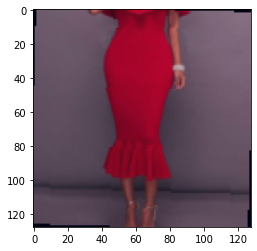

In [ ]:
def denorm(img_tensors): #this function will denormalize the tensors 
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*dataset[180]) #let's take an example

In [ ]:
val_percent = int(0.25 * len(dataset)) #setting 25 percent of the total number of images for validation
train_size = len(dataset) - val_percent
val_size = len(dataset) - train_size
train_size, val_size

(8539, 2846)

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size]) #splitting the dataset for training and validation.
len(train_ds), len(val_ds)

(8539, 2846)

In [ ]:
#setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size * 2)

In [ ]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 128, 128])
torch.Size([32, 11])


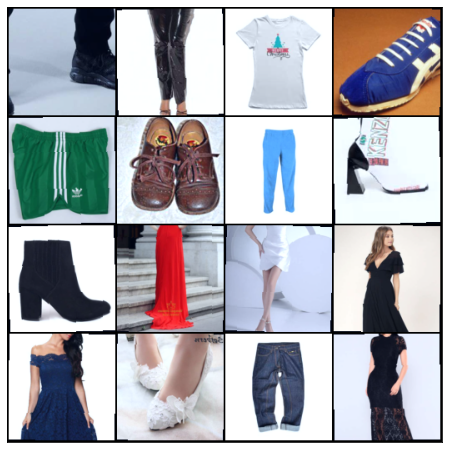

In [ ]:
#let's see a batch of images (16 images) in a grid
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(images[:nmax]), nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [ ]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)


class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_score': score.detach() }      


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 128 x 128
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 128 x 128
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 128 x 128


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 32 x 32
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 32 x 32  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 8 x 8
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 8 x 8


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 2 x 2
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 2 x 2


        self.classifier = nn.Sequential(nn.MaxPool2d(2), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 11     

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = F.sigmoid(out)
        return out

In [ ]:
model = (ResNet15(3, len(classes))) #input size: 3, output size: 11, loading model onto GPU
model

ResNet15(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=Fa

In [ ]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([32, 3, 128, 128])
outputs.shape :  torch.Size([32, 11])
Sample outputs :
 tensor([[0.6298, 0.4333, 0.4013, 0.4698, 0.3557, 0.8499, 0.3102, 0.6697, 0.9347,
         0.8866, 0.1622],
        [0.5270, 0.6607, 0.3941, 0.5084, 0.5228, 0.6411, 0.2414, 0.5576, 0.7498,
         0.6409, 0.3610]])


In [ ]:
history = [evaluate(model, val_loader)]
history

In [ ]:
epochs = 3
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/267 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0010, train_loss: 0.1414, val_loss: 0.1743, val_score: 0.8028


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0005, train_loss: 0.1041, val_loss: 0.0708, val_score: 0.9279


  0%|          | 0/267 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0000, train_loss: 0.0590, val_loss: 0.0489, val_score: 0.9519
CPU times: user 3h 14min 36s, sys: 35min 55s, total: 3h 50min 31s
Wall time: 4h 5min 3s


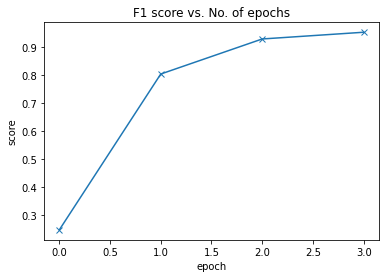

In [32]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

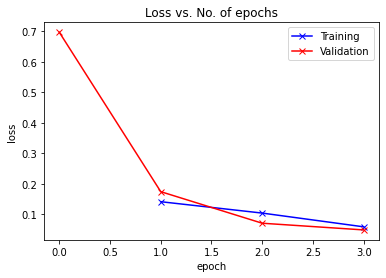

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

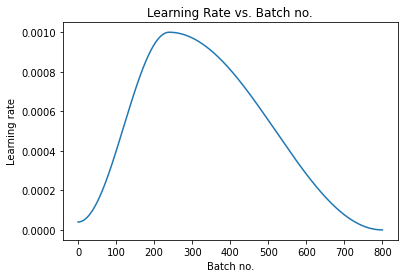

In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [35]:
def predict_single(image):
    xb = image.unsqueeze(0)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)

Label: red dress

tensor([2.9815e-05, 1.1271e-05, 6.0494e-08, 7.9316e-09, 1.7303e-05, 9.9997e-01,
        9.9997e-01, 4.4345e-05, 3.2599e-08, 2.6256e-06, 3.3535e-07],
       grad_fn=<SelectBackward0>)


Label: green shoes

tensor([2.9453e-03, 8.6211e-04, 1.2173e-04, 9.9663e-01, 3.9243e-05, 1.9192e-03,
        2.4642e-05, 4.3355e-05, 1.3072e-04, 9.9972e-01, 3.5373e-04],
       grad_fn=<SelectBackward0>)
Label: blue dress

tensor([3.1883e-04, 9.9621e-01, 7.6493e-06, 6.1198e-07, 4.1299e-04, 3.4765e-04,
        9.9093e-01, 3.9618e-03, 6.8773e-04, 1.5074e-03, 5.7590e-03],
       grad_fn=<SelectBackward0>)


Label: blue dress

tensor([1.2118e-02, 9.9100e-01, 1.8071e-04, 3.8177e-05, 8.8477e-04, 4.7236e-04,
        9.7014e-01, 2.5517e-03, 1.1345e-02, 6.7474e-03, 6.3513e-03],
       grad_fn=<SelectBackward0>)


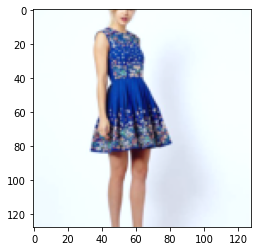

In [36]:
#checking out the predictions of some images from the validation dataset
predict_single(val_ds[200][0])
predict_single(val_ds[145][0])
predict_single(val_ds[500][0])
predict_single(val_ds[700][0])

In [37]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = T.ToTensor()(image).unsqueeze(0)
    image_tensor = T.Resize([128,128])(image_tensor)
    image_tensor = T.Normalize(*imagenet_stats)(image_tensor)
    #print(image_tensor.shape)
    preds = model(image_tensor)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([9.9865e-01, 1.1898e-03, 1.6897e-04, 1.3090e-04, 1.2849e-05, 1.5899e-04,
        8.4704e-01, 4.3069e-04, 8.5879e-03, 3.4333e-02, 1.7372e-02],
       grad_fn=<SelectBackward0>)

Label: black dress


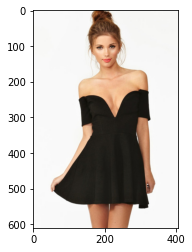

In [42]:
random_image_prediction('http://picture-cdn.wheretoget.it/e07ql5-l-610x610-dress-little+black+dress-skater+dress-nastygal-deep+vneck-short-formal-short+formal+dress-prom-short+prom+dress-black-lbd-short+black+dress-prom+dress-black+dress-blackdress-short+.jpg')

In [41]:
# Save the model
torch.save(model.state_dict(), "drive/My Drive/Hack the Mist/model_weights.pt")